In [1]:
import tensorflow as tf

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
%matplotlib inline

In [8]:
df = pd.read_csv('Downloads/RSCCASN.csv',parse_dates=True,index_col='DATE')

In [9]:
df

,RSCCASN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2019-06-01,21123
2019-07-01,21714
2019-08-01,23791


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 334 entries, 1992-01-01 to 2019-10-01
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   RSCCASN  334 non-null    int64
dtypes: int64(1)
memory usage: 5.2 KB


In [11]:
df.columns = ['Sales']

In [12]:
df

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2019-06-01,21123
2019-07-01,21714
2019-08-01,23791


<AxesSubplot:xlabel='DATE'>

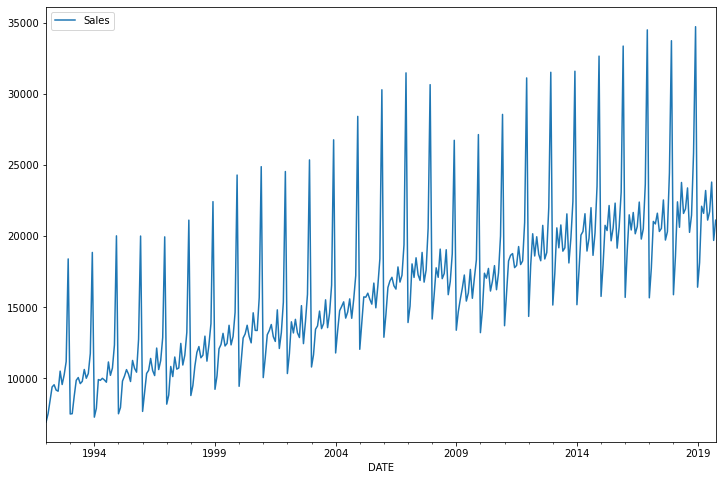

In [13]:
df.plot(figsize=(12,8))

In [14]:
len(df)

334

In [15]:
#Train Test Split

In [16]:
len(df) - 18

316

In [17]:
test_size = 18
test_ind = len(df) - test_size

In [18]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [19]:
train

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2017-12-01,33720
2018-01-01,15881
2018-02-01,18585


In [20]:
test

,Sales
DATE,
2018-05-01,23764
2018-06-01,21589
2018-07-01,21919
2018-08-01,23381
2018-09-01,20260
2018-10-01,21473
2018-11-01,25831
2018-12-01,34706
2019-01-01,16410


In [21]:
from sklearn.preprocessing import MinMaxScaler

In [22]:
scaler = MinMaxScaler()

In [23]:
scaler.fit(train)

MinMaxScaler()

In [24]:
scaled_train = scaler.transform(train)

In [25]:
scaled_test = scaler.transform(test)

In [26]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [27]:
len(test)

18

In [28]:
length = 12
generator = TimeseriesGenerator(scaled_train,scaled_train,length=length,batch_size=1)

In [29]:
X,y = generator[0]

In [30]:
X

array([[[0.        ],
        [0.02127505],
        [0.05580163],
        [0.08942056],
        [0.09512053],
        [0.08146965],
        [0.07860151],
        [0.12979233],
        [0.09566512],
        [0.1203892 ],
        [0.15426227],
        [0.41595266]]])

In [31]:
y

array([[0.02047633]])

In [32]:
#Creating the model

In [44]:
from tensorflow.keras.models import Sequential

In [45]:
from tensorflow.keras.layers import Dense,LSTM

In [46]:
n_features = 1

In [47]:
model = Sequential()
model.add(LSTM(100,activation='relu',input_shape=(length,n_features)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

In [48]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [49]:
from tensorflow.keras.callbacks import EarlyStopping

In [50]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [51]:
validation_generator = TimeseriesGenerator(scaled_test,scaled_test,length=length,batch_size=1)

In [52]:
model.fit_generator(generator,epochs=10,validation_data=validation_generator)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 304 steps, validate for 6 steps
Epoch 1/10
304/304 [==============================] - 3s 10ms/step - loss: 0.0248 - val_loss: 0.0490
Epoch 2/10
304/304 [==============================] - 2s 5ms/step - loss: 0.0178 - val_loss: 0.0075
Epoch 3/10
304/304 [==============================] - 2s 5ms/step - loss: 0.0112 - val_loss: 9.8295e-04
Epoch 4/10
304/304 [==============================] - 2s 6ms/step - loss: 0.0052 - val_loss: 6.0302e-04
Epoch 5/10
304/304 [==============================] - 2s 5ms/step - loss: 0.0024 - val_loss: 3.5219e-04
Epoch 6/10
304/304 [==============================] - 2s 5ms/step - loss: 0.0011 - val_loss: 0.0021
Epoch 7/10
304/304 [==============================] - 2s 5ms/step - loss: 0.0016 - val_loss: 0.0032
Epoch 8/10
304/304 [==============================] - 2s 5ms/step - loss: 0.0013 - val_loss: 0.0061
Epoch 9/10
304/304 [==============================] - 2s 5ms/step - loss: 0.0013 - val_loss: 2.

In [53]:
losses = pd.DataFrame(model.history.history)

<AxesSubplot:>

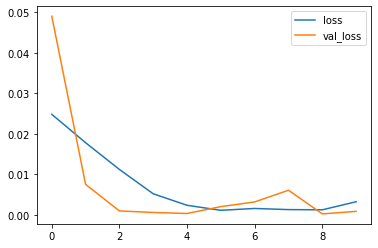

In [54]:
losses.plot()

In [55]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [56]:
true_predictions = scaler.inverse_transform(test_predictions)

In [57]:
test['Predictions'] = true_predictions

C:\Users\Riya\.conda\envs\tf\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [58]:
test

,Sales,Predictions
DATE,,
2018-05-01,23764,22016.728195
2018-06-01,21589,20793.970604
2018-07-01,21919,21001.198899
2018-08-01,23381,22903.199498
2018-09-01,20260,20278.624353
2018-10-01,21473,20897.978772
2018-11-01,25831,25002.966984
2018-12-01,34706,35192.588947
2019-01-01,16410,16263.945544


<AxesSubplot:xlabel='DATE'>

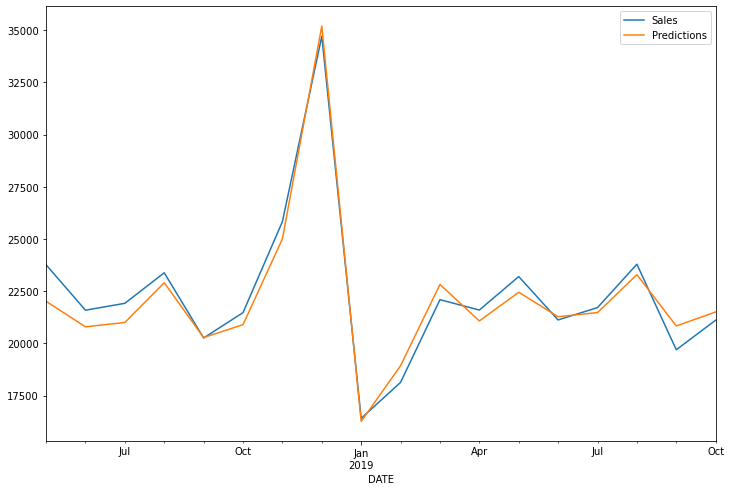

In [60]:
test.plot(figsize=(12,8))

In [61]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [62]:
length = 12
generator = TimeseriesGenerator(scaled_full_data,scaled_full_data,length=length,batch_size=1)

In [63]:
model = Sequential()

In [64]:
model = Sequential()
model.add(LSTM(100,activation='relu',input_shape=(length,n_features)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

model.fit_generator(generator,epochs=8)

  ...
    to  
  ['...']
Train for 322 steps
Epoch 1/8
322/322 [==============================] - 3s 9ms/step - loss: 0.0242
Epoch 2/8
322/322 [==============================] - 2s 5ms/step - loss: 0.0160
Epoch 3/8
322/322 [==============================] - 2s 5ms/step - loss: 0.0126
Epoch 4/8
322/322 [==============================] - 2s 5ms/step - loss: 0.0049
Epoch 5/8
322/322 [==============================] - 2s 5ms/step - loss: 0.0032
Epoch 6/8
322/322 [==============================] - 2s 5ms/step - loss: 0.0028
Epoch 7/8
322/322 [==============================] - 2s 5ms/step - loss: 0.0015
Epoch 8/8
322/322 [==============================] - 2s 5ms/step - loss: 0.0022


In [65]:
forecast = []
periods=12

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store predictio
    forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [66]:
forecast = scaler.inverse_transform(forecast)

In [67]:
df

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2019-06-01,21123
2019-07-01,21714
2019-08-01,23791


In [68]:
forecast

array([[26991.0281353 ],
       [38602.8294611 ],
       [18307.95918822],
       [19851.82262278],
       [23127.60214233],
       [22869.26616001],
       [24394.64594841],
       [22634.32347822],
       [23282.61456728],
       [25246.07901525],
       [21782.44878054],
       [22940.47543907]])

In [69]:
forecast_index = pd.date_range(start='2019-11-01',periods=periods,freq="MS")

In [70]:
forecast_index

DatetimeIndex(['2019-11-01', '2019-12-01', '2020-01-01', '2020-02-01',
               '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
               '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01'],
              dtype='datetime64[ns]', freq='MS')

In [73]:
forecast_df = pd.DataFrame(data=forecast,index=forecast_index,columns=['Forecast'])

In [74]:
forecast_df

,Forecast
2019-11-01,26991.028135
2019-12-01,38602.829461
2020-01-01,18307.959188
2020-02-01,19851.822623
2020-03-01,23127.602142
2020-04-01,22869.266160
2020-05-01,24394.645948
2020-06-01,22634.323478
2020-07-01,23282.614567
2020-08-01,25246.079015


<AxesSubplot:>

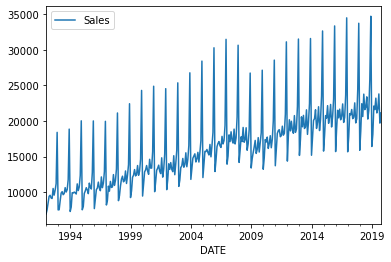

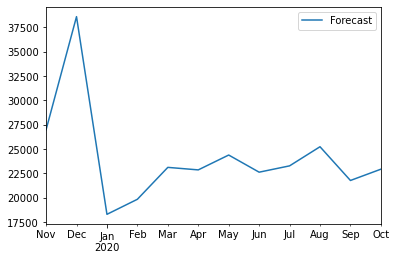

In [77]:
df.plot()
forecast_df.plot()

<AxesSubplot:xlabel='DATE'>

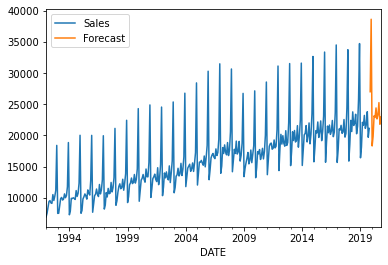

In [78]:
ax = df.plot()
forecast_df.plot(ax=ax)

(576.0, 611.0)

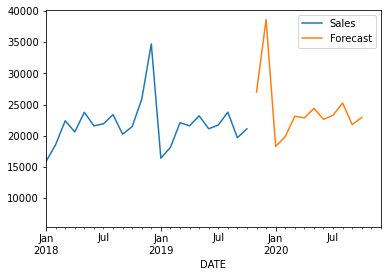

In [79]:
ax = df.plot()
forecast_df.plot(ax=ax)
plt.xlim('2018-01-01','2020-12-01')